## 1. This notebook scraps the data from the IRDAI website using the PAN numbers
## 2. We use 10,000,000 randomly generated PAN numbers to hit the website 30,000,000 times and get the data
## 3. The IRDAI website presents a CAPTCHA everytime we hit it, so this code also automatically solves the CAPTCHA. This is the USP of our srapping process

In [1]:
#Installations 
#!pip install requests
#!pip install pandas
#!pip install matplotlib
#!pip install pytesseract
#!pip install opencv-python
#!pip install getch
#brew install imagemagick #Install this in the mac terminal
#!pip install requests_cache

In [40]:
#All the imports are list
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import requests
import shutil
import pytesseract
import sys
import cv2
import os
from PIL import Image
from PIL import ImageFilter
import getch
import numpy as np
import requests_cache #Using cache to avoid multiple requests while testing
import warnings
warnings.filterwarnings("ignore")#Ignoring warnings to clean up the notebook
import tqdm
import concurrent.futures, threading #For Multi-Threading
import multiprocessing as mp 
import time #to record the start and the endtimes

## We make a pandas dataframe to store the data

In [41]:
#This is the structure of our dataframe we use to keep the data
col_base=['PAN',
 'Aadhaar',
 'Agent Name',
 'Date of Birth',
 'Insurer Type',
 'Insurer',
 'Agency Code',
 'Date of Appointment',
 'Status of agency',
 'Status Change Date',
 'License No. If any previously held']
df=pd.DataFrame(columns=col_base) 
cookie=''

## Here we make a function to get a cookie everytime the website is hit for the first time. Since we hit the website from many different computers, we get a cookie everytime

In [42]:
def get_new_cookie(url, session, cookie=''):
    if(len(cookie)<1): #If cookie is not present ,get cookie
        payload={
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en;q=0.9",
        "Cache-Control": "max-age=0",
        "Connection": "keep-alive",
        "Host": "agencyportal.irdai.gov.in",
        "Referer": "https://www.google.com/",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "cross-site",
        "Sec-Fetch-User": "?1",
        "Sec-GPC": "1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
        }
    else:
         payload={
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en;q=0.9",
        "Cache-Control": "max-age=0",
        "Connection": "keep-alive",
        "Cookie":cookie,
        "Host": "agencyportal.irdai.gov.in",
        "Referer": "https://www.google.com/",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "cross-site",
        "Sec-Fetch-User": "?1",
        "Sec-GPC": "1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
        }

    try:
        r=session.get(url,headers=payload, verify=False)#,headers=payload)
    except:
        print ("Error")
    if (r.cookies.get_dict().get('ASP.NET_SessionId')):
        cookie=str("ASP.NET_SessionId")+"="+str(r.cookies.get_dict().get('ASP.NET_SessionId'))
        print("cookie_chanaged")
    soup = bs(r.text)
    return cookie, soup

## This is the solve CAPTCHA function. It blurs the image, thresholds it and uses Optical Character recognition to finally solve the CAPTCHA

## We break the CAPTCHA with a good succes. Our accuracy is 85% which means that we are able to break the CPATCHA correctly every 85 times out of the 200 times

In [43]:
def get_solve_CAPTCHA(url, cookie, session):
    payload={
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en;q=0.9",
        "Cache-Control": "max-age=0",
        "Connection": "keep-alive",
        "Cookie":cookie,
        "Host": "agencyportal.irdai.gov.in",
        "Referer": "https://agencyportal.irdai.gov.in/PublicAccess/LookUpPAN.aspx",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "cross-site",
        "Sec-Fetch-User": "?1",
        "Sec-GPC": "1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
        }


    headers = {}
    
    try:
        img_r=session.get(url,headers=payload, stream=True, verify=False).raw #Getting the image here
    except:
        print ("Error")

    try:
        img = np.asarray(bytearray(img_r.read()), dtype="uint8") #Converting the image to a numpy array
        image = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE) #Converting to Grayscale
        del img
    except:
        print("!!!!!!!!!!!!!!!!CAPTCHA not received!!!!!!!!!!!!")
        
        
    cv2.imwrite('temp.jpeg',image)
    command="convert temp.jpeg -scale 175% -blur 2x4 -resize 1000% -threshold 68% temp.png" #Blur and Threshold
    os.system(command)
    retval=cv2.imread('temp.png')
    result = pytesseract.image_to_string(retval[100:900,200:2400],lang='eng',config='-c tessedit_char_whitelist=abcdef0123456789 --psm 8') #Reading image with Tesseract
    result = result.strip(' \n')
    return result

## After getting the cookie and the CPATCHA information, we finally hit the website for data

In [44]:

def scrap_data(url, cookie, session, result, pan, soup):
    data={
        str(soup.find("input",{"name":"__EVENTTARGET"}).get('name')):str(soup.find("input",{"name":"__EVENTTARGET"}).get('value')), 
        str(soup.find("input",{"name":"__EVENTARGUMENT"}).get('name')):str(soup.find("input",{"name":"__EVENTARGUMENT"}).get('value')),
        str(soup.find("input",{"name":"__VIEWSTATE"}).get('name')):str(soup.find("input",{"name":"__VIEWSTATE"}).get('value')),
        str(soup.find("input",{"name":"__VIEWSTATEGENERATOR"}).get('name')):str(soup.find("input",{"name":"__VIEWSTATEGENERATOR"}).get('value')),
        str(soup.find("input",{"name":"__SCROLLPOSITIONX"}).get('name')):str(soup.find("input",{"name":"__SCROLLPOSITIONX"}).get('value')),
        str(soup.find("input",{"name":"__SCROLLPOSITIONY"}).get('name')):str(soup.find("input",{"name":"__SCROLLPOSITIONY"}).get('value')),
        str(soup.find("input",{"name":"__EVENTVALIDATION"}).get('name')):str(soup.find("input",{"name":"__EVENTVALIDATION"}).get('value')),
        "ctl00$ContentPlaceHolder1$RadioButtonPanAdhar":"PAN",
        "ctl00$ContentPlaceHolder1$PAN_Details":pan,
        "ctl00$ContentPlaceHolder1$txtcaptcha":result,
        "ctl00$ContentPlaceHolder1$btn_lookup":"Submit"
        }
    
    payload={
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3",
        "Accept-Encoding":"gzip, deflate",
        "Accept-Language":"en-US,en;q=0.5",
        "Connection":"keep-alive",
        "Cache-Control": "max-age=0",
        "Connection": "keep-alive",
        "Content-Length": "986",
        "Content-Type": "application/x-www-form-urlencoded",
        "Cookie":cookie,
        "Host": "agencyportal.irdai.gov.in",
        "Origin": "https://agencyportal.irdai.gov.in",
        "Referer": "https://agencyportal.irdai.gov.in/PublicAccess/LookUpPAN.aspx",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "same-origin",
        "Sec-Fetch-User": "?1",
        "Sec-GPC": "1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.75 Safari/537.36"
        }
    headers = {}
    
    try:
        result=session.post(url,data=data,headers=payload, verify=False)
    except:
        print ("Error")

    soup = bs(result.text)
    a=soup.find( "div", {"id":"ctl00_ContentPlaceHolder1_divPan"})
    return a,result

## This is the finction which initiates the call to all other functions

In [45]:
def get_parsed_data(pan):
    global cookie
    #captcha_miss_count = 0
    session = requests_cache.CachedSession('demo_cache')
    dict_list=[]
    #for pan in tqdm.tqdm(pan_list):
    url = 'https://agencyportal.irdai.gov.in/PublicAccess/LookUpPAN.aspx'
    cookie, soup = get_new_cookie(url, session, cookie )

    url = 'https://agencyportal.irdai.gov.in/_Handler/CaptchaCodeGeneration.ashx'
    result = get_solve_CAPTCHA(url, cookie, session)

    url='https://agencyportal.irdai.gov.in/PublicAccess/LookUpPAN.aspx'
    a, result=scrap_data(url, cookie, session, result, pan, soup)

    col=[]
    for i in a.findAll("th",{"scope":"col"}):
        col.append(i.text) 

    for i in a.findAll("tr",{"align":"center"}):
        k=0
        new_dict=dict()
        for j in i.findAll("td"):
            new_dict.update({col[k]:j.text})
            k=k+1
        dict_list.append(new_dict)

        #if 'enter valid captcha' in result.text.lower():
            #captcha_miss_count+=1
    
    #print('The CAPTCHA solving accuracy is: ',1-captcha_miss_count/len(pan_list))
    return dict_list

## Reading the randomly generated PAN card numbers

In [46]:
pan_list=pd.read_csv('Data/PAN.csv')
pan_list=list(pan_list['PAN'])

## Hitiing the website

In [47]:
#pan_list=["AAAAA1234A"]
start_time = time.time()
dict_list=[]
for pan in tqdm.tqdm(pan_list):#(list(pan_list[0])):
    dict_list.extend(get_parsed_data(pan))
print(time.time() - start_time)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

cookie_chanaged


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.28s/it]

4.287690877914429


## Please use the parallization below to hit the website, set it according to your OS

## Finally saving the scrapped data

In [26]:
df.to_csv('scrapping_data.csv',index=False)

## Misc, Not the a part of the code
## Here is what the CAPTCHA solving looks like

In [55]:
payload={
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en;q=0.9",
        "Cache-Control": "max-age=0",
        "Connection": "keep-alive",
        "Cookie":cookie,
        "Host": "agencyportal.irdai.gov.in",
        "Referer": "https://agencyportal.irdai.gov.in/PublicAccess/LookUpPAN.aspx",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "cross-site",
        "Sec-Fetch-User": "?1",
        "Sec-GPC": "1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
        }


headers = {}

url = 'https://agencyportal.irdai.gov.in/_Handler/CaptchaCodeGeneration.ashx'
session = requests_cache.CachedSession('demo_cache')

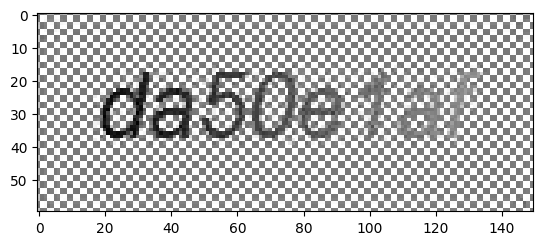

In [71]:
try:
    img_r=session.get(url,headers=payload, stream=True, verify=False).raw
except:
    print ("Error")

try:
    img = np.asarray(bytearray(img_r.read()), dtype="uint8")
    image = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)
    del img
except:
    print("!!!!!!!!!!!!!!!!CAPTCHA not received!!!!!!!!!!!!")


cv2.imwrite('temp.jpeg',image)
plt.imshow(image,cmap='gray')

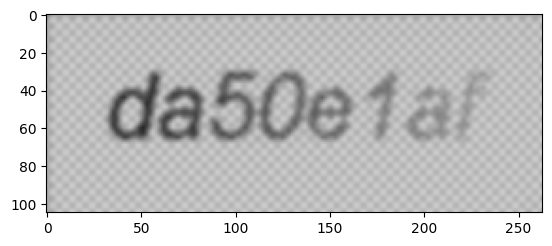

In [72]:
#Scaling and blurring the Image
command="convert temp.jpeg -scale 175% -blur 2x4 temp.png"
os.system(command)
retval=cv2.imread('temp.png')
plt.imshow(retval,cmap='gray')

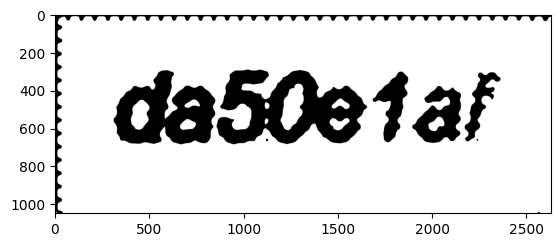

In [73]:
#Threshholding and re-scaling Image
command="convert temp.png -resize 1000% -threshold 68% temp.png"
os.system(command)
retval=cv2.imread('temp.png')
plt.imshow(retval,cmap='gray')

In [74]:
#Reading the image with OCR
result = pytesseract.image_to_string(retval[100:900,200:2400],lang='eng',config='-c tessedit_char_whitelist=abcdef0123456789 --psm 8')
result = result.strip(' \n')
print(result)

da50e1af


In [76]:
df.columns.values

array(['PAN', 'Aadhaar', 'Agent Name', 'Date of Birth', 'Insurer Type',
       'Insurer', 'Agency Code', 'Date of Appointment',
       'Status of agency', 'Status Change Date',
       'License No. If any previously held'], dtype=object)